In [1]:
from __future__ import print_function, division

import sys
import platform
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# this is necessary to use the common functions
# assumes directory structure was maintained
sys.path.insert(0, '../common/')
# from common.torch_utils import train_model,get_device
# from torch_utils import (train_model, 
#                          mnist_dataloader, 
#                          dataset_preview)
from torch_utils import *

# print some versions
print(f'Python Version:      {platform.python_version()}')
print(f'PyTorch Version:     {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')
print(f'CUDA Version:        {torch.version.cuda}')

Python Version:      3.7.8
PyTorch Version:     1.7.1+cu101
Torchvision Version: 0.8.2+cu101
CUDA Version:        10.1


In [3]:
 # use a GPU if there is one available
device = get_device()


***********************************
GPU Available:  True
Current Device: cuda:0 (Tesla T4)
***********************************



Data will be located in '../../data'
Dataset sizes: {'train': 60000, 'val': 9900, 'pred': 100}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


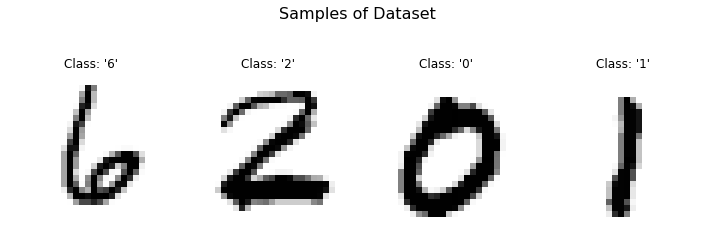

In [38]:
BATCH_SIZE = 32

data_transforms = {
    'train': transforms.Compose([
        # transform.Resize(224,224), # MNIST are 28x28, ResNet used 224x224
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        # transform.Resize(224,224), # MNIST are 28x28, ResNet used 224x224
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

# use helper to create the dataloaders
tmp = mnist_dataloader(data_transforms,batch_size=BATCH_SIZE,pred_size=0.01)
dataloaders, dataset_sizes, class_names = tmp 
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders['val'])

In [26]:
# Use Torchvision Resnet18 for base model since our 
# dataset is small and only has 10 classes
model = models.resnet18(pretrained=True)

# prepare the pre-trained model: 
#   Note the following considerations given our dataset for ResNet
#     -> MNIST data are 1-channel (grascale) of size and has 10 output classes
#     -> ResNet model expects 3-channel (RGB) images of size 224x224 as input 
#        and has 1000 output classes
#     == We must changet the last fully connected layer to match 10 classes, 
#        and transform the input to be 224
# keep features unchanged
num_features = model.fc.in_features
# change the output layer to match number of new classes
num_classes = 10
model.fc = nn.Linear(num_features, num_classes)
# change the first conv layer for single channel images
model.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
# ref: https://discuss.pytorch.org/t/altering-resnet18-for-single-channel-images/29198/10

# move model to the GPU
cudnn.benchmark = True

# use helper function to train the model (outputs model and Pandas DF)
model, results_df,_ = train_model(device, model, dataloaders, 
                                  dataset_sizes, num_epochs=3)

# save the data for others to use
# results_file = 'resnet18_{}.csv'.format(hardware)
# df_path = os.path.join(save_dir,results_file)
# results_df.to_csv(df_path,columns=results_df.columns)


Epoch 0/2
----------
train Loss: 1.133 Acc: 0.7064
val Loss: 0.2452 Acc: 0.9249

Epoch 1/2
----------
train Loss: 0.1772 Acc: 0.9472
val Loss: 0.086 Acc: 0.9718

Epoch 2/2
----------
train Loss: 0.1155 Acc: 0.9645
val Loss: 0.0727 Acc: 0.9753
Training complete in 1.0m 30.064563512802124s
Best val Acc: 0.9753


tensor([1, 8, 3, 0, 2, 5, 1, 6, 0, 4, 8, 4, 1, 6, 3, 0, 5, 4, 8, 3, 3, 9, 6, 0,
        3, 5, 7, 9, 7, 5, 2, 3])


[]

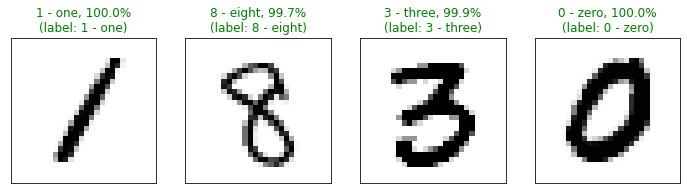

In [54]:
# Evaluate the model using the prediction set held-off
model.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()